In [1]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import sklearn
import os
import dill as pickle
from itertools import combinations
import random
import tensorflow as tf

from keras.models import Model, Input, Sequential, load_model
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, ZeroPadding2D, Dropout
from keras.optimizers import SGD,Adam
import keras.metrics
from keras.utils import plot_model
from src.models import history
from keras.callbacks import ModelCheckpoint

from src.data import process_audio
from src.data import display_audio
from src.data import process_audio_siam
from src.models import one_shot_learning
from src.data import process_audio_VGG16_features
from src.models import one_shot_learning_VGG16
from src.data import audio_to_features_bal


In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [98]:
# Load train data
data_900 = pickle.load(open('/Users/greenapple/project5/data/processed/train_data_900.pkl', 'rb')) # 10 speakers, 10 audios per speaker
data_100 = data_900[:1000]
data_100.shape

(1000, 4)

In [99]:
# Reshape data for the siamese model before modeling:
X, y, siam_data, X_res_data = audio_to_features_bal.dataframe_to_siamese_features(data_100)

In [100]:
X.shape

(9000, 2, 7, 7, 512)

In [101]:
siam_data.siam_targets.value_counts()

0    495000
1      4500
Name: siam_targets, dtype: int64

In [110]:
# Load test data
test_data_40 = pickle.load(
    open('/Users/greenapple/project5/data/processed/test_data_40.pkl', 'rb')
)

# Siamese same weights with VGG16 embeddings.  100 speakers, balanced data.

### Epochs 0-25

In [102]:
# One dense layer
input_shape = (7, 7, 512)   

inputs = Input(input_shape)
output = Flatten()(inputs) 
encodings = Dense(4096, activation='sigmoid')(output)


one_dense = Model(inputs=inputs, outputs=encodings, name='one_dense')
one_dense.compile(optimizer=Adam(lr = 0.00006), 
                  loss='categorical_crossentropy')


# Define tensors for two input audios
input_shape = (7, 7, 512)

left_input = Input(input_shape)
right_input = Input(input_shape)    

encoded_l = one_dense(left_input)
encoded_r = one_dense(right_input)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_same_weights = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_same_weights.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


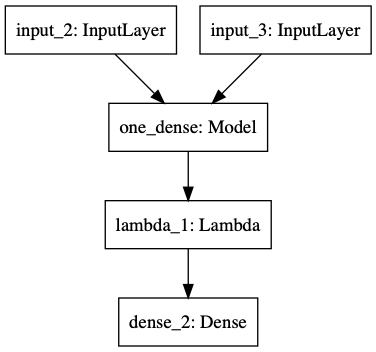

In [103]:
plot_model(siamese_same_weights)

In [113]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_same_weights_bal.h5', 
                             monitor='val_acc', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_same_weights
history_siamese_same_weights = model.fit([X[:, 0], X[:, 1]], 
                                         y, 
                                         validation_split=0.2, 
                                         epochs=25, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history_siamese_dist_weights.history['acc'])
plt.plot(history_siamese_dist_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 7200 samples, validate on 1800 samples
Epoch 1/25
7200/7200 [==============================] - 487s 68ms/step - loss: 0.5474 - acc: 0.7081 - val_loss: 1.4607 - val_acc: 0.0211

Epoch 00001: val_acc improved from -inf to 0.02111, saving model to siamese_same_weights_bal.h5
Epoch 2/25
7200/7200 [==============================] - 444s 62ms/step - loss: 0.3702 - acc: 0.8740 - val_loss: 2.1305 - val_acc: 0.0061

Epoch 00002: val_acc did not improve from 0.02111
Epoch 3/25
7200/7200 [==============================] - 443s 62ms/step - loss: 0.2456 - acc: 0.9519 - val_loss: 2.8046 - val_acc: 0.0044

Epoch 00003: val_acc did not improve from 0.02111
Epoch 4/25
7200/7200 [==============================] - 442s 61ms/step - loss: 0.1569 - acc: 0.9815 - val_loss: 3.3105 - val_acc: 0.0044

Epoch 00004: val_acc did not improve from 0.02111
Epoch 5/25
7200/7200 [==============================] - 446s 62ms/step - loss: 0.0989 - acc: 0.9943 - val_loss: 3.8800 - val_acc: 0.0044

Epoch 00005: val

NameError: name 'history_siamese_dist_weights' is not defined

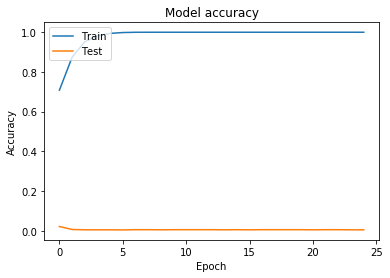

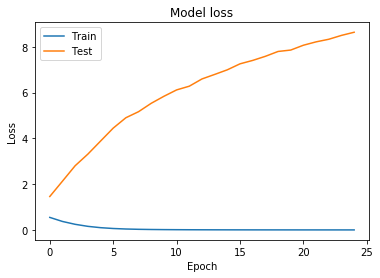

In [114]:
# Plot training & validation accuracy values
plt.plot(history_siamese_same_weights.history['acc'])
plt.plot(history_siamese_same_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_siamese_same_weights.history['loss'])
plt.plot(history_siamese_same_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

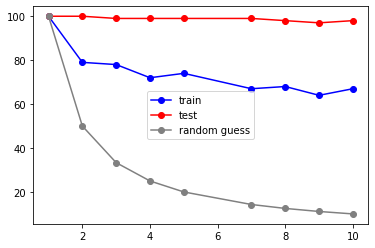

In [115]:
# One shot learning score:
model = siamese_same_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_100
speaker_data_test = test_data_40

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    

### Epochs 25-30

Train on 7200 samples, validate on 1800 samples
Epoch 1/5
7200/7200 [==============================] - 477s 66ms/step - loss: 6.9652e-04 - acc: 1.0000 - val_loss: 8.7313 - val_acc: 0.0044

Epoch 00001: val_acc improved from -inf to 0.00444, saving model to siamese_same_weights_bal.h5
Epoch 2/5
7200/7200 [==============================] - 459s 64ms/step - loss: 6.0304e-04 - acc: 1.0000 - val_loss: 8.8789 - val_acc: 0.0044

Epoch 00002: val_acc did not improve from 0.00444
Epoch 3/5
7200/7200 [==============================] - 448s 62ms/step - loss: 5.2344e-04 - acc: 1.0000 - val_loss: 8.9988 - val_acc: 0.0050

Epoch 00003: val_acc improved from 0.00444 to 0.00500, saving model to siamese_same_weights_bal.h5
Epoch 4/5
7200/7200 [==============================] - 442s 61ms/step - loss: 4.5542e-04 - acc: 1.0000 - val_loss: 9.0967 - val_acc: 0.0056

Epoch 00004: val_acc improved from 0.00500 to 0.00556, saving model to siamese_same_weights_bal.h5
Epoch 5/5
7200/7200 [=======================

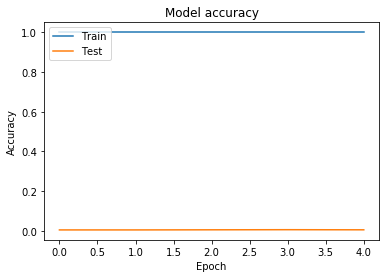

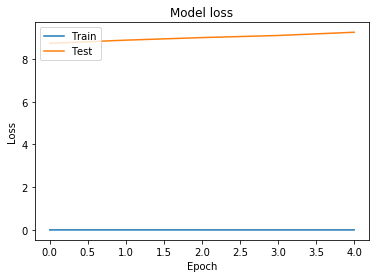

In [116]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_same_weights_bal.h5', 
                             monitor='val_acc', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_same_weights
history_siamese_same_weights_25_30 = model.fit([X[:, 0], X[:, 1]], 
                                         y, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history_siamese_same_weights_25_30.history['acc'])
plt.plot(history_siamese_same_weights_25_30.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_siamese_same_weights_25_30.history['loss'])
plt.plot(history_siamese_same_weights_25_30.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

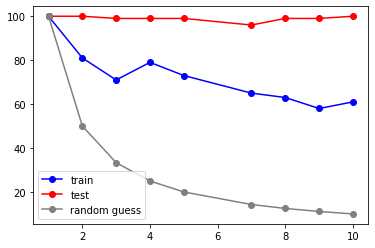

In [117]:
# One shot learning score:
model = siamese_same_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_100
speaker_data_test = test_data_40

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    